# Lab 9 - PCC177/BCC406

## REDES NEURAIS E APRENDIZAGEM EM PROFUNDIDADE

## NLP

### Prof. Eduardo e Prof. Pedro

Objetivos:

- Implementar técncias de PLN para resolver um problema de classificação de texto tóxico em portugues.
- Utilizar *Word2Vec* e *BERT*.

Data da entrega : Fim do período

- Complete o código (marcado com ToDo) e quando requisitado, escreva textos diretamente nos notebooks. Onde tiver *None*, substitua pelo seu código.
- Execute todo notebook e salve tudo em um PDF **nomeado** como "NomeSobrenome-Lab.pdf"
- Envie o PDF via google [FORM](https://forms.gle/eJf6nX7fwuV18Map7)

Este notebook é baseado em tensorflow e Keras.

Links de tutoriais úteis:
 - https://jalammar.github.io/illustrated-word2vec/
 - https://jalammar.github.io/illustrated-gpt2/
 - https://jalammar.github.io/illustrated-bert/
 - https://huggingface.co/neuralmind/bert-base-portuguese-cased
 - https://github.com/neuralmind-ai/portuguese-bert
 - https://huggingface.co/models?other=word2vec
 - https://huggingface.co/fse/word2vec-google-news-300
 - https://huggingface.co/docs/transformers/main_classes/pipelines
 - https://huggingface.co/docs/transformers/v4.18.0/en/autoclass_tutorial
 - https://huggingface.co/docs/transformers/tasks/sequence_classification

# Importando bibliotecas e preparando o ambiente

Importando as bibliotecas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten

Montando o seu drive no colab.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 Vamos carregar a base de dados "*Brazilian Portuguese Hatespeech dataset*". Para detalhes sobre o dataset e o problema em si, veja o [link do Kaggle](https://www.kaggle.com/datasets/hrmello/brazilian-portuguese-hatespeech-dataset/).

In [3]:
# Ler o arquivo CSV hate_speech_binary_classification_train.csv dentro da pasta de dataset do drive compartilhado.
# Substitua o 'caminho_do_arquivo_treino.csv' pelo caminho real do seu arquivo CSV
dados = pd.read_csv('/content/drive/MyDrive/datasets/hate_speech_binary_classification_train.csv')

# Ler o arquivo CSV hate_speech_binary_classification_test.csv dentro da pasta de dataset do drive compartilhado.
# Substitua o 'caminho_do_arquivo_teste.csv' pelo caminho real do seu arquivo CSV
dados_teste = pd.read_csv('/content/drive/MyDrive/datasets/hate_speech_binary_classification_test.csv')

Mostrar as primeiras linhas do DataFrame

In [4]:
print(dados.head())

                                                text  \
0  -Odeio feministas só falam merda\n-Vamos fazer...   
1  CHEGOU DANDO CANTADA NO CARNAVAL:\n#CarnavalSe...   
2  Diferença entre 'manifestante' e 'terrorista'....   
3  É legal pra um presidente 'grampear' uma corri...   
4  não há como negar a biologia....por mais que a...   

                                             protext  class  
0  -Odeio feministas só falam merda -Vamos fazer ...      1  
1  CHEGOU DANDO CANTADA NO CARNAVAL: #CarnavalSem...      0  
2  Diferença entre 'manifestante' e 'terrorista'....      1  
3  É legal pra um presidente 'grampear' uma corri...      0  
4  não há como negar a biologia....por mais que a...      0  


## Pré-processando os dados

Selecionando colunas específicas

In [5]:
dados_brutos = dados.iloc[:, 0]
X = dados.iloc[:, 1] # Coluna dos dados pré-processados
y = dados.iloc[:, 2] # Coluna dos rótulos

X_test = dados_teste.iloc[:, 1]  # Coluna dos dados pré-processados
y_test = dados_teste.iloc[:, 2]  # Coluna dos rótulos

Mostrar as primeiras linhas de cada coluna

In [6]:
print("Dados brutos:")
print(dados_brutos.head())
print("\nRótulos:")
print(y.head())
print("\nDados preprocessados:")
print(X.head())

Dados brutos:
0    -Odeio feministas só falam merda\n-Vamos fazer...
1    CHEGOU DANDO CANTADA NO CARNAVAL:\n#CarnavalSe...
2    Diferença entre 'manifestante' e 'terrorista'....
3    É legal pra um presidente 'grampear' uma corri...
4    não há como negar a biologia....por mais que a...
Name: text, dtype: object

Rótulos:
0    1
1    0
2    1
3    0
4    0
Name: class, dtype: int64

Dados preprocessados:
0    -Odeio feministas só falam merda -Vamos fazer ...
1    CHEGOU DANDO CANTADA NO CARNAVAL: #CarnavalSem...
2    Diferença entre 'manifestante' e 'terrorista'....
3    É legal pra um presidente 'grampear' uma corri...
4    não há como negar a biologia....por mais que a...
Name: protext, dtype: object


# Uma implementação ingênua para o problema

Abaixo uma implementação ingênua para o problema. Ela é ingênua por que desconsidera a ordem das palavras no texto.
Tente endendê-la e execute o treinamento.

### Pré-processamento

Primeira coisa é fixar as sementes para garantir a reproducibilidade dos resultados

In [7]:
np.random.seed(94)
tf.random.set_seed(94)

Codificação dos rótulos para 0 e 1

In [8]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y_test = encoder.transform(y_test)

Tokenização e sequenciamento dos textos

In [9]:
max_length = 280  # Define o tamanho máximo das sequências
vocab_size = 100000  # Define o tamanho do vocabulário

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X)
# Tokenização e sequenciamento dos textos de treino
sequences = tokenizer.texts_to_sequences(X)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Tokenização e sequenciamento dos textos de teste
sequences_test = tokenizer.texts_to_sequences(X_test)
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_length, padding='post', truncating='post')

Divisão dos dados em conjuntos de treino e validação

In [10]:
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

### Aplicando uma estratégia ingênua

Definição do modelo

In [11]:
embedding_dim = 16

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

Compilação do modelo

In [12]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Visualizando os dados

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 280, 16)           1600000   
                                                                 
 flatten (Flatten)           (None, 4480)              0         
                                                                 
 dense (Dense)               (None, 32)                143392    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1743425 (6.65 MB)
Trainable params: 1743425 (6.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Treinamento do modelo

In [14]:
epochs = 5
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=2)

Epoch 1/5
72/72 - 11s - loss: 0.6944 - accuracy: 0.4983 - val_loss: 0.6933 - val_accuracy: 0.4965 - 11s/epoch - 154ms/step
Epoch 2/5
72/72 - 3s - loss: 0.6933 - accuracy: 0.4790 - val_loss: 0.6931 - val_accuracy: 0.5035 - 3s/epoch - 47ms/step
Epoch 3/5
72/72 - 3s - loss: 0.6932 - accuracy: 0.4991 - val_loss: 0.6931 - val_accuracy: 0.5035 - 3s/epoch - 36ms/step
Epoch 4/5
72/72 - 1s - loss: 0.6932 - accuracy: 0.4808 - val_loss: 0.6931 - val_accuracy: 0.5035 - 1s/epoch - 17ms/step
Epoch 5/5
72/72 - 1s - loss: 0.6932 - accuracy: 0.4834 - val_loss: 0.6931 - val_accuracy: 0.5035 - 1s/epoch - 17ms/step


Plotando as curvas de loss

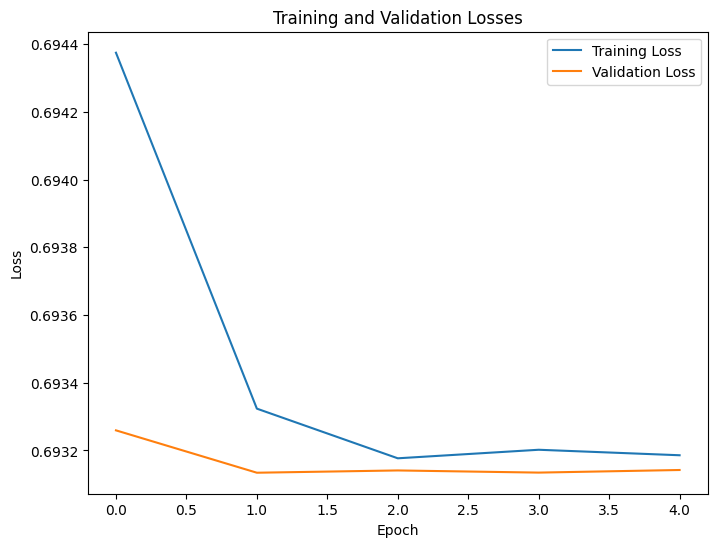

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Avaliação do modelo

Avaliar o modelo nos dados de teste


In [16]:
loss, accuracy = model.evaluate(padded_sequences_test, y_test, verbose=2)
print(f"Perda nos dados de teste: {loss:.4f}")
print(f"Acurácia nos dados de teste: {accuracy:.4f}")

23/23 - 0s - loss: 0.6931 - accuracy: 0.5000 - 65ms/epoch - 3ms/step
Perda nos dados de teste: 0.6931
Acurácia nos dados de teste: 0.5000


Previsões do modelo

In [18]:
y_pred = (model.predict(padded_sequences_test) > 0.5).astype("int32")

23/23 [==============================] - 0s 2ms/step


Gerando o relatório de classificação

In [19]:
report = classification_report(y_test, y_pred, target_names=encoder.classes_, output_dict=True)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotando os resultados

In [20]:
print("Classificação Report:")
for label, metrics in report.items():
    if label == 'accuracy':
        continue
    print(f"Class: {label}")
    print(f"\tPrecision: {metrics['precision']}")
    print(f"\tRecall: {metrics['recall']}")
    print(f"\tF1-score: {metrics['f1-score']}")
print(f"Macro Avg: {report['macro avg']}")
print(f"Weighted Avg: {report['weighted avg']}")

Classificação Report:
Class: 0
	Precision: 0.5
	Recall: 1.0
	F1-score: 0.6666666666666666
Class: 1
	Precision: 0.0
	Recall: 0.0
	F1-score: 0.0
Class: macro avg
	Precision: 0.25
	Recall: 0.5
	F1-score: 0.3333333333333333
Class: weighted avg
	Precision: 0.25
	Recall: 0.5
	F1-score: 0.3333333333333333
Macro Avg: {'precision': 0.25, 'recall': 0.5, 'f1-score': 0.3333333333333333, 'support': 716}
Weighted Avg: {'precision': 0.25, 'recall': 0.5, 'f1-score': 0.3333333333333333, 'support': 716}


Plotando a matriz de confusão

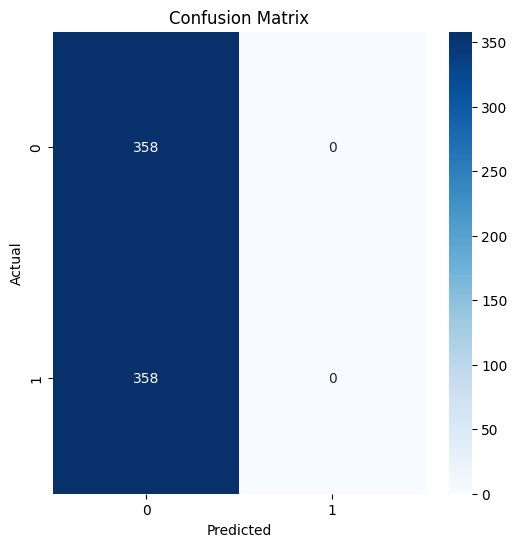

In [21]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

\\# Faça o mesmo processamento utilizando *Word2Vec* pré-treinado em inglês

In [4]:
# ToDo: Siga como base o tutorial presente em https://czarrar.github.io/Gensim-Word2Vec/
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
#import umap.umap_ as umap
import matplotlib.pyplot as plt

glove2word2vec("/content/drive/MyDrive/datasets/glove.6B.100d.txt", "/content/drive/MyDrive/datasets/glove_model2.txt")


model = Word2Vec(size=100, min_count=1)
model.build_vocab(sents)
total_examples = model.corpus_count

# Save the vocab of your dataset
vocab = list(model.wv.vocab.keys())


pretrained_path = "/path/to/glove/glove_model2.txt"
model_2 = KeyedVectors.load_word2vec_format(pretrained_path, binary=False)

# Add the pre-trained model vocabulary
model.build_vocab([list(model_2.vocab.keys())], update=True)

# Load the pre-trained models embeddings
# note: if a word doesn't exist in the pre-trained vocabulary then it is left as is in the original model
model.intersect_word2vec_format(pretrained_path, binary=False, lockf=1.0)

model.train(sents3, total_examples=total_examples, epochs=model.epochs)

word_embeddings = np.array([ model.wv[k] if k in model.wv else np.zeros(100) for k in vocab ])
word_embeddings.shape # Should be len(vocab) by 100


#from sklearn.preprocessing import StandardScaler

#scaled_we = StandardScaler().fit_transform(word_embeddings)
#embedding2d = reducer.fit_transform(scaled_we)

reducer = umap.UMAP()
embedding2d = reducer.fit_transform(word_embeddings)


plt.scatter(
    embedding2d[:, 0],
    embedding2d[:, 1])

<ipython-input-4-7aafe1e857ae>:10: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec("/content/drive/MyDrive/datasets/glove.6B.100d.txt", "/content/drive/MyDrive/datasets/glove_model2.txt")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/datasets/glove.6B.100d.txt'

# Faça o mesmo processamento utilizando *Word2Vec* pré-treinado a partir do português

In [ ]:
# ToDo: Siga o mesmo tutorial anterior, mas com o Word2Vec para pt: https://github.com/rdenadai/WordEmbeddingPortugues

# Faça o mesmo processamento utilizando *BERT* de inglês

In [ ]:
# ToDo: Siga de base o seguinte tutorial https://huggingface.co/docs/transformers/training

# Faça o mesmo processamento utilizando *BERT* de português

In [ ]:
# ToDo: Siga o mesmo tutorial anterior, mas com o BERT para pt: https://huggingface.co/neuralmind/bert-base-portuguese-cased

# *ToDo*: O que você pode analisar dos modelos treinados?

```
  Coloque a sua resposta aqui
```